In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import mixed_precision
from extra_models.object_detector import ObjectDetector
import matplotlib.pyplot as plt
from model_trainer import create_train_dataset

In [2]:
%matplotlib inline

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [4]:
data_dir = 'data/val'
img_size = (640,480)
class_names = ['food']
bbox_sizes = [(25,25)]

In [5]:
ds = create_train_dataset(data_dir, img_size, class_names, bbox_sizes, val_data=True)

In [6]:
backbone_f = 'hr_5_3_8'
intermediate_filters = 256
kernel_size = 16
stride = 8
num_classes = len(class_names) + 1

In [7]:
test_model = ObjectDetector(
    backbone_f,
    intermediate_filters,
    kernel_size,
    stride,
    img_size,
    num_classes,
)

In [8]:
load_dir = 'savedmodels/hr538_m_f1/10'
test_model.load_weights(load_dir)

----deltas
tf.Tensor(
[[  0.6839105   -1.8984125   -0.4935172    1.6629252 ]
 [ -5.2505465   -1.7538528   -2.2190914   -3.0858574 ]
 [ -5.2070274  -15.900872    -4.8977537   -3.75262   ]
 ...
 [  3.611507    -3.2797768    0.3176267    2.5848916 ]
 [  0.34979513   0.7925464    4.7495003  -10.969932  ]
 [ -0.63209724 -26.195877    -3.3920922   -4.08482   ]], shape=(41949, 4), dtype=float32)
tf.Tensor(
[[ 0.0541441  -1.2923596   0.14143224  0.21054512]
 [-1.5087415  -1.0087539  -1.4778243  -0.98281205]], shape=(2, 4), dtype=float32)
(2000, 4)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)
----deltas
tf.Tensor(
[[  0.6784421   -1.8995607   -0.49479297   1.6588945 ]
 [ -5.2510147   -1.7668395   -2.2142725   -3.0908995 ]
 [ -5.203253   -15.879501    -4.8932457   -3.7757447 ]
 ...
 [  3.6203532   -3.286103     0.31653285   2.5828602 ]
 [  0.34316757   0.81056845   4.7567773  -10.962543  ]
 [ -0.6505499  -26.205296    -3.3962994   -4.0832615 ]], shape=(41949, 4), dtype=float32)
tf.Tensor(

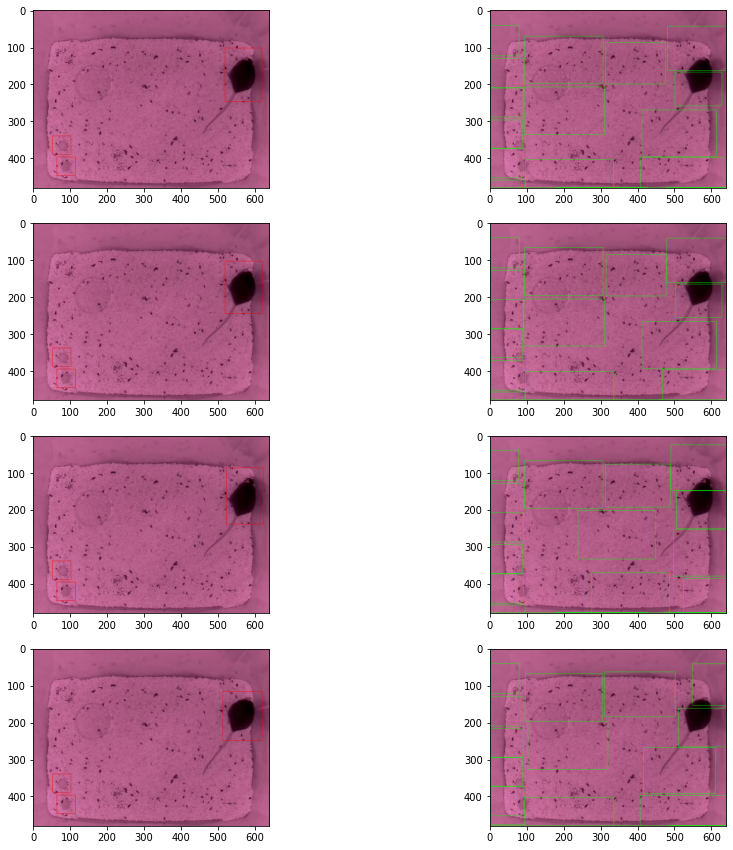

In [11]:
samples = ds.take(4).as_numpy_iterator()
fig = plt.figure(figsize=(15,15))
for i in range(4):
    sample = next(samples)
    image, gt_box, _ = sample
    rois, probs = test_model(image, training=False)
    test_image = image[0].copy()
    gt_image = image[0].copy()
    gt_box = gt_box[0]
    h,w = np.subtract(gt_image.shape[:2],1)
    print(rois.shape)
    print(rois[500])
    for roi in rois.numpy():

        x1, y1, x2, y2 = (roi*np.array([w,h,w,h,])).astype(np.int64)
        test_image[y1,x1:x2] = [0,1,0]
        test_image[y2,x1:x2] = [0,1,0]
        test_image[y1:y2,x1] = [0,1,0]
        test_image[y1:y2,x2] = [0,1,0]
    for box in gt_box:
        x1, y1, x2, y2 = (box*np.array([w,h,w,h,])).astype(np.int64)
        gt_image[y1,x1:x2] = [1,0,0]
        gt_image[y2,x1:x2] = [1,0,0]
        gt_image[y1:y2,x1] = [1,0,0]
        gt_image[y1:y2,x2] = [1,0,0]

    ax = fig.add_subplot(4,2,2*i+1)
    ax.imshow(gt_image)
    ax = fig.add_subplot(4,2,2*i+2)
    ax.imshow(test_image)
plt.show()
